In [57]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
import plotly.graph_objs as go

import geopandas
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import seaborn as sb
import plotly
import dash
import plotly.offline as ply
from plotly.graph_objs import *
from scipy.io import netcdf
import scipy.stats as stat

origins = ["DR_Congo", "Afghanistan", "Syria", "Myanmar", "Sudan"]
destinations = ["USA", "UK", "France", "Canada", "Italy", "Germany"]

org_codes = ["COD", "AFG", "SYR", "MMR", "SDN"]
dest_codes = ["USA", "GBR", "FRA", "CAN", "ITA","DEU"]

years = [2000 + i for i in range(19)]

features = ['destination',
 'Origin',
 'applied',
 'accepted',
 'Rejected',
 'decisions',
 'Year',
 'Month',
 'Value',
 'deaths',
 'last_month',
 'two_months_ago',
 'next_month',
 'two_months_later']


months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]

combos = []
for year in years:
    for month in months:
        combos.append((month, year))


coordinates = {}
coordinates["Syria"] = (34.8, 38.997)
coordinates["DR_Congo"] = (-4.0383, 21.759)
coordinates["Afghanistan"] = (33.939, 67.71)
coordinates["Sudan"] = (12.863, 30.218)
coordinates["Myanmar"] = (21.9162, 95.956)

coordinates["USA"] = (37.09, -95.713)
coordinates["UK"] = (55.378, -3.436)
coordinates["France"] = (46.228, 2.214)
coordinates["Germany"] = (51.166, 10.4515)
coordinates["Italy"] = (41.872, 12.5674)
coordinates["Canada"] = (56.1304, -106.3468)


dest_longs = [coordinates[dest][1] for dest in destinations]
dest_lats = [coordinates[dest][0] for dest in destinations]

org_longs = [coordinates[org][1] for org in origins]
org_lats = [coordinates[org][0] for org in origins]

pairs = []
for origin in origins:
    for destination in destinations:
        pairs.append((origin, destination))

# Read in data
df = pd.read_csv('./data/all_merged.csv', skipinitialspace=True)

symbols = {'DR_Congo': 'triangle-down', 'Sudan': 'square', 'Syria': 'cross',\
            'Myanmar':'star', 'Afghanistan': 'circle'}

In [58]:
for month in months:
    df.ix[df.Month.str.contains(month), ['Month']] = month
month_ids = []
markers = []
origin_ids = []
d_lats = []
d_longs = []
o_lats = []
o_longs = []
for index, row in df.iterrows():
    markers.append(symbols[row["Origin"]])
    month = row.Month
    month_ids.append(months.index(month) + 1)
    origin_ids.append(origins.index(row.Origin))
    d_lats.append(coordinates[row.destination][0])
    o_lats.append(coordinates[row.Origin][0])
    d_longs.append(coordinates[row.destination][1])
    o_longs.append(coordinates[row.Origin][1])
df['shapes'] = markers
df['month_id'] = month_ids
df['month_number'] =12*(df['Year']-2000) + df['month_id']
df['origin_id'] = origin_ids
df['dest_lat'] = d_lats
df['dest_long'] = d_longs
df['org_lat'] = o_lats
df['org_long'] = o_longs

/Users/jasonterry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



In [59]:
list(df)

['Unnamed: 0',
 'destination',
 'Origin',
 'applied',
 'accepted',
 'Rejected',
 'decisions',
 'Year',
 'Month',
 'Value',
 'deaths',
 'shapes',
 'month_id',
 'month_number',
 'origin_id',
 'dest_lat',
 'dest_long',
 'org_lat',
 'org_long']

In [51]:
grouped = df.groupby('destination')

In [52]:
group_dict = {}
for (name, df) in grouped:
    group_dict[name] = df

In [53]:
group_dict[list(group_dict.keys())[0]].sample(5)

,Unnamed: 0,destination,Origin,applied,accepted,Rejected,decisions,Year,Month,Value,deaths,shapes,month_id,month_number,origin_id
1958,1958,USA,Myanmar,264.0,246.0,138.0,481.0,2005,Jun,19.0,142.0,star,6,66,3
2075,2075,USA,Afghanistan,45.0,42.0,39.0,130.0,2005,Jul,1.0,1736.0,circle,7,67,1
5147,5147,USA,Sudan,182.0,92.0,33.0,187.0,2013,Feb,5.0,1519.0,square,2,158,4
136,136,USA,Afghanistan,443.0,333.0,82.0,523.0,2000,May,20.0,5235.0,circle,5,5,1
711,711,USA,Afghanistan,499.0,341.0,70.0,521.0,2001,Dec,14.0,5308.0,circle,12,24,1


## Plot with dropdown menu that chooses origin. Shows all refugees for each country

In [36]:
fig = go.FigureWidget(
    data=[dict(
        x = df.query('Origin == @origin')['month_number'],
        y = df.query('Origin == @origin')['Value'],
        name = origin, 
        mode = 'markers',
        opacity = 0.6
    ) for origin in origins
    ]
)
years = [2000 + i for i in range(18)]
marker_places= [12*i for i in range(18)]
tick_labs = [str(year) for year in years]
fig.layout.hovermode = 'closest'
fig.layout.yaxis.title = 'Refugees Taken In'
# fig.layout.xaxis.title = 'Month'
fig.layout.xaxis.ticktext = tick_labs
fig.layout.xaxis.tickvals = marker_places

In [37]:
from ipywidgets import interact

@interact(menu = destinations)
def update_arguments(menu=['Canada']):
    for i in range(len(fig.data)):
        origin = fig.data[i]['name']
        fig.data[i].x = group_dict[menu].query('Origin == @origin')\
                        .month_number
        fig.data[i].y = group_dict[menu].query('Origin == @origin')\
                        .Value + \
                        np.random.rand(len(group_dict[menu]\
                                           .query('Origin == @origin')\
                        .month_number))
    fig.layout.title = 'Refugees taken in by ' + menu
fig

interactive(children=(Dropdown(description='menu', options=('USA', 'UK', 'France', 'Canada', 'Italy', 'Germany…

FigureWidget({
    'data': [{'mode': 'markers',
              'name': 'DR_Congo',
              'opacity': 0.6…

## Routes

In [68]:
dest_dict = [ dict(
        type = 'scattergeo',
        locationmode = 'world',
        lon = dest_longs,
        lat = dest_lats,
        hoverinfo = 'text',
        text = destinations,
        mode = 'markers',
        marker = dict( 
            size=2, 
            color='rgb(255, 0, 0)',
            line = dict(
                width=3,
                color='rgba(68, 68, 68, 0)'
            )
        ))]

In [69]:
org_dict = [ dict(
        type = 'scattergeo',
        locationmode = 'world',
        lon = org_longs,
        lat = org_lats,
        hoverinfo = 'text',
        text = origins,
        mode = 'markers',
        marker = dict( 
            size=2, 
            color='rgb(255, 0, 0)',
            line = dict(
                width=3,
                color='rgba(68, 68, 68, 0)'
            )
        ))]

In [78]:
df.describe()

,Unnamed: 0,applied,accepted,Rejected,decisions,Year,Value,deaths,month_id,month_number,origin_id,dest_lat,dest_long,org_lat,org_long
count,6921.000000,6921.000000,6921.000000,6921.000000,6921.000000,6921.000000,6.921000e+03,6.921000e+03,6921.000000,6921.000000,6921.000000,6921.000000,6921.000000,6921.000000,6921.000000
mean,3460.000000,2191.110967,921.466262,627.635168,2350.696865,2008.357029,1.597301e+02,6.135324e+03,6.490825,106.775177,1.977171,46.797137,-36.959863,19.781876,49.502858
std,1998.064939,14459.155648,8685.692228,3025.026421,16026.344974,5.129547,1.348388e+03,1.437154e+04,3.454863,61.648128,1.428973,7.407505,51.762354,14.653953,26.551705
min,0.000000,0.000000,0.000000,0.000000,0.000000,2000.000000,2.744706e-19,9.676108e-18,1.000000,1.000000,0.000000,37.090000,-106.346800,-4.038300,21.759000
25%,1730.000000,101.000000,33.000000,26.000000,111.000000,2004.000000,4.000000e+00,1.970000e+02,3.000000,54.000000,1.000000,37.090000,-95.713000,12.863000,30.218000
50%,3460.000000,288.000000,100.000000,71.000000,286.000000,2008.000000,1.500000e+01,8.560000e+02,6.000000,106.000000,2.000000,46.228000,-3.436000,21.916200,38.997000
75%,5190.000000,835.000000,290.000000,242.000000,850.000000,2013.000000,5.400000e+01,3.597000e+03,10.000000,159.000000,3.000000,55.378000,10.451500,33.939000,67.710000
max,6920.000000,268866.000000,172319.000000,61311.000000,304912.000000,2017.000000,3.686000e+04,6.971200e+04,12.000000,216.000000,4.000000,56.130400,12.567400,34.800000,95.956000


In [79]:
possible_locationmodes = ['ISO-3', 'USA-states', 'country names']
paths = []
colors = ['red', 'blue', 'green', 'orange', 'purple']
for i in range(len(df.Value)):
    paths.append(
        dict(
            type = 'scattergeo',
            locationmode = 'country names',
            lon = [df['org_long'][i], df['dest_long'][i] ],
            lat = [ df['org_lat'][i], df['dest_lat'][i] ],
            mode = 'lines',
            line = dict(
                width = 1,
                color = colors[df['origin_id'][i]],
            ),
            opacity = 0.4,
        )
    )

In [82]:
layout = dict(
        title = 'Refugee Routes (2000 - 2018)',
        showlegend = False, 
        geo = dict(
            scope='world',
#             projection=dict( type='mercator' ),
            projection = dict(type = 'azimuthal equal area'),
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )

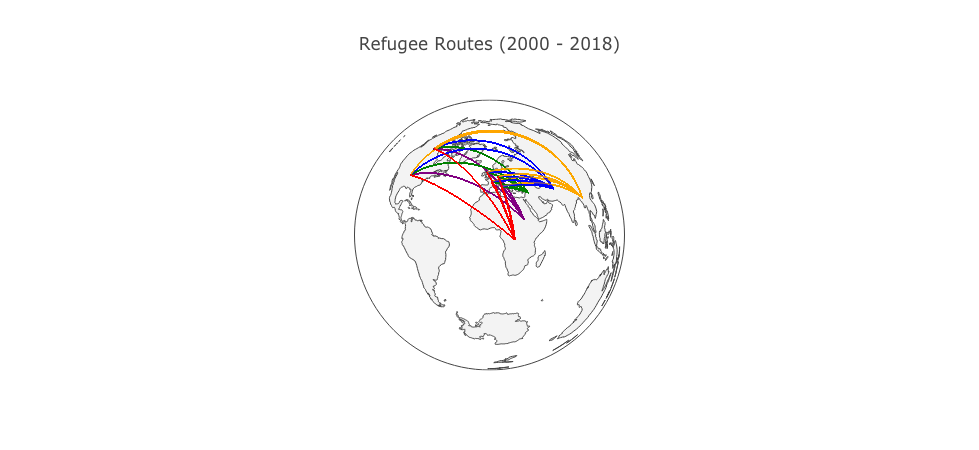

In [83]:
fig = dict(data=paths, layout=layout )
ply.iplot( fig, filename='refugee routes' )
# fig